# Taxa de inflação global (2023)

Gráfico visualizando a taxa de inflação global no ano de 2023 utilizando os dados fornecidos no site da Kaggle. 
https://www.kaggle.com/code/bencross1110/global-inflation-visualisations

Começando importando as bibliotecas

In [57]:
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import pandas as pd
from pypalettes import load_cmap
from highlight_text import fig_text, ax_text
from pyfonts import load_font

Então lemos o arquivo com as coordenadas do globo

In [58]:
df = gpd.read_file('world.geojson')
df.rename(columns={'ADM0_A3':'country_code'}, inplace=True)
df.head()

,NAME,NAME_LONG,country_code,ISO_A2,ISO_A3,WB_A2,WB_A3,geometry
0,Afghanistan,Afghanistan,AFG,AF,AFG,AF,AFG,"POLYGON ((74.8923 37.2311, 74.4873 37.2259, 74..."
1,Angola,Angola,AGO,AO,AGO,AO,AGO,"MULTIPOLYGON (((23.9675 -10.8723, 24.0112 -11...."
2,Albania,Albania,ALB,AL,ALB,AL,ALB,"POLYGON ((20.065 42.5468, 20.2496 42.3186, 20...."
3,Aland,Aland Islands,ALD,AX,ALA,-99,-99,"POLYGON ((19.9185 60.3702, 20.2776 60.2787, 20..."
4,Andorra,Andorra,AND,AD,AND,AD,ADO,"POLYGON ((1.707 42.5028, 1.4479 42.4346, 1.429..."


Aqui lemos o arquivo com os dados referentes a inflação e filtramos o ano de 2023 pra visualizarmos

In [59]:
inflation = pd.read_csv('global_inflation_countries.csv')
inflation = inflation[inflation['year'] == 2023]
inflation.reset_index()
inflation.head()

,country_code,country_name,region,sub_region,intermediate_region,indicator_code,indicator_name,year,inflation_rate
63,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,FP.CPI.TOTL.ZG,"INFLACION, PRECIOS AL CONSUMIDOR (% ANUAL)",2023,0.000000
127,ALB,ALBANIA,EUROPA Y ASIA CENTRAL (EXCLUIDO ALTOS INGRESOS),SOUTHERN EUROPE,NaN,FP.CPI.TOTL.ZG,"INFLACION, PRECIOS AL CONSUMIDOR (% ANUAL)",2023,4.759764
191,DEU,ALEMANIA,NaN,WESTERN EUROPE,NaN,FP.CPI.TOTL.ZG,"INFLACION, PRECIOS AL CONSUMIDOR (% ANUAL)",2023,5.946437
255,AND,ANDORRA,NaN,SOUTHERN EUROPE,NaN,FP.CPI.TOTL.ZG,"INFLACION, PRECIOS AL CONSUMIDOR (% ANUAL)",2023,0.000000
319,AGO,ANGOLA,ÁFRICA AL SUR DEL SAHARA (EXCLUIDO ALTOS INGRE...,SUB-SAHARAN AFRICA,MIDDLE AFRICA,FP.CPI.TOTL.ZG,"INFLACION, PRECIOS AL CONSUMIDOR (% ANUAL)",2023,13.644102


Nessa parte criamos um dataframe mesclando as informações dos dois arquivos e adicionamos um percentual de inflação. Assim como criamos uma tabela agrupada com rotulos de acordo com o seu percentual, além de adicionarmos um campo com o valor máximo e valor minimo de cada grupo.

In [175]:
bins = [0.0,0.75,0.80,0.85,0.90,0.95,0.98,0.99,1.0]
labels = [
    '0.75 ou menos',
    '0.76 a 0.80',
    '0.81 a 0.85',
    '0.86 a 0.90',
    '0.91 a 0.95',
    '0.96 a 0.98',
    '0.981 a 0.99',
    '0.991 ou mais'
    
]

atlas = pd.merge(df,inflation,how='right',on=['country_code']).reset_index()
atlas['pct_rank'] = atlas['inflation_rate'].rank(pct=True)

atlas['group_inflation'] = pd.cut(atlas['pct_rank'], bins=bins, labels=labels)
inflation_group_max = atlas.groupby('group_inflation', observed=True)['inflation_rate'].max().reset_index()
inflation_group_min = atlas.groupby('group_inflation', observed=True)['inflation_rate'].min().reset_index()
# inflation_group = inflation_group.drop(index=0)

inflation_group = pd.merge(inflation_group_max, inflation_group_min, how='inner', on='group_inflation')
inflation_group['inflation_rate_x'] = inflation_group['inflation_rate_x'].round(2)
inflation_group['inflation_rate_y'] = inflation_group['inflation_rate_y'].round(2)
inflation_group.replace(to_replace=-1.04, value=0, inplace=True)
inflation_group['label'] = inflation_group['inflation_rate_y'].astype(str) + ' a ' + inflation_group['inflation_rate_x'].astype(str)

inflation_group

,group_inflation,inflation_rate_x,inflation_rate_y,label
0,0.75 ou menos,7.80,0.00,0.0 a 7.8
1,0.76 a 0.80,9.16,7.81,7.81 a 9.16
2,0.81 a 0.85,10.35,9.28,9.28 a 10.35
3,0.86 a 0.90,12.85,10.40,10.4 a 12.85
4,0.91 a 0.95,28.79,13.42,13.42 a 28.79
5,0.96 a 0.98,38.11,30.22,30.22 a 38.11
6,0.981 a 0.99,47.64,44.58,44.58 a 47.64
7,0.991 ou mais,221.34,51.59,51.59 a 221.34


Nessa parte enfim geramos um Choropleth, começamos com o gráfico do mapa mundi com a paleta de cores de acordo com o seu percentual de inflação. Em seguida geramos um Barplot dentro do primeiro gráfico usando nossa tabela agrupada. Por fim adicionamos algumas anotações.

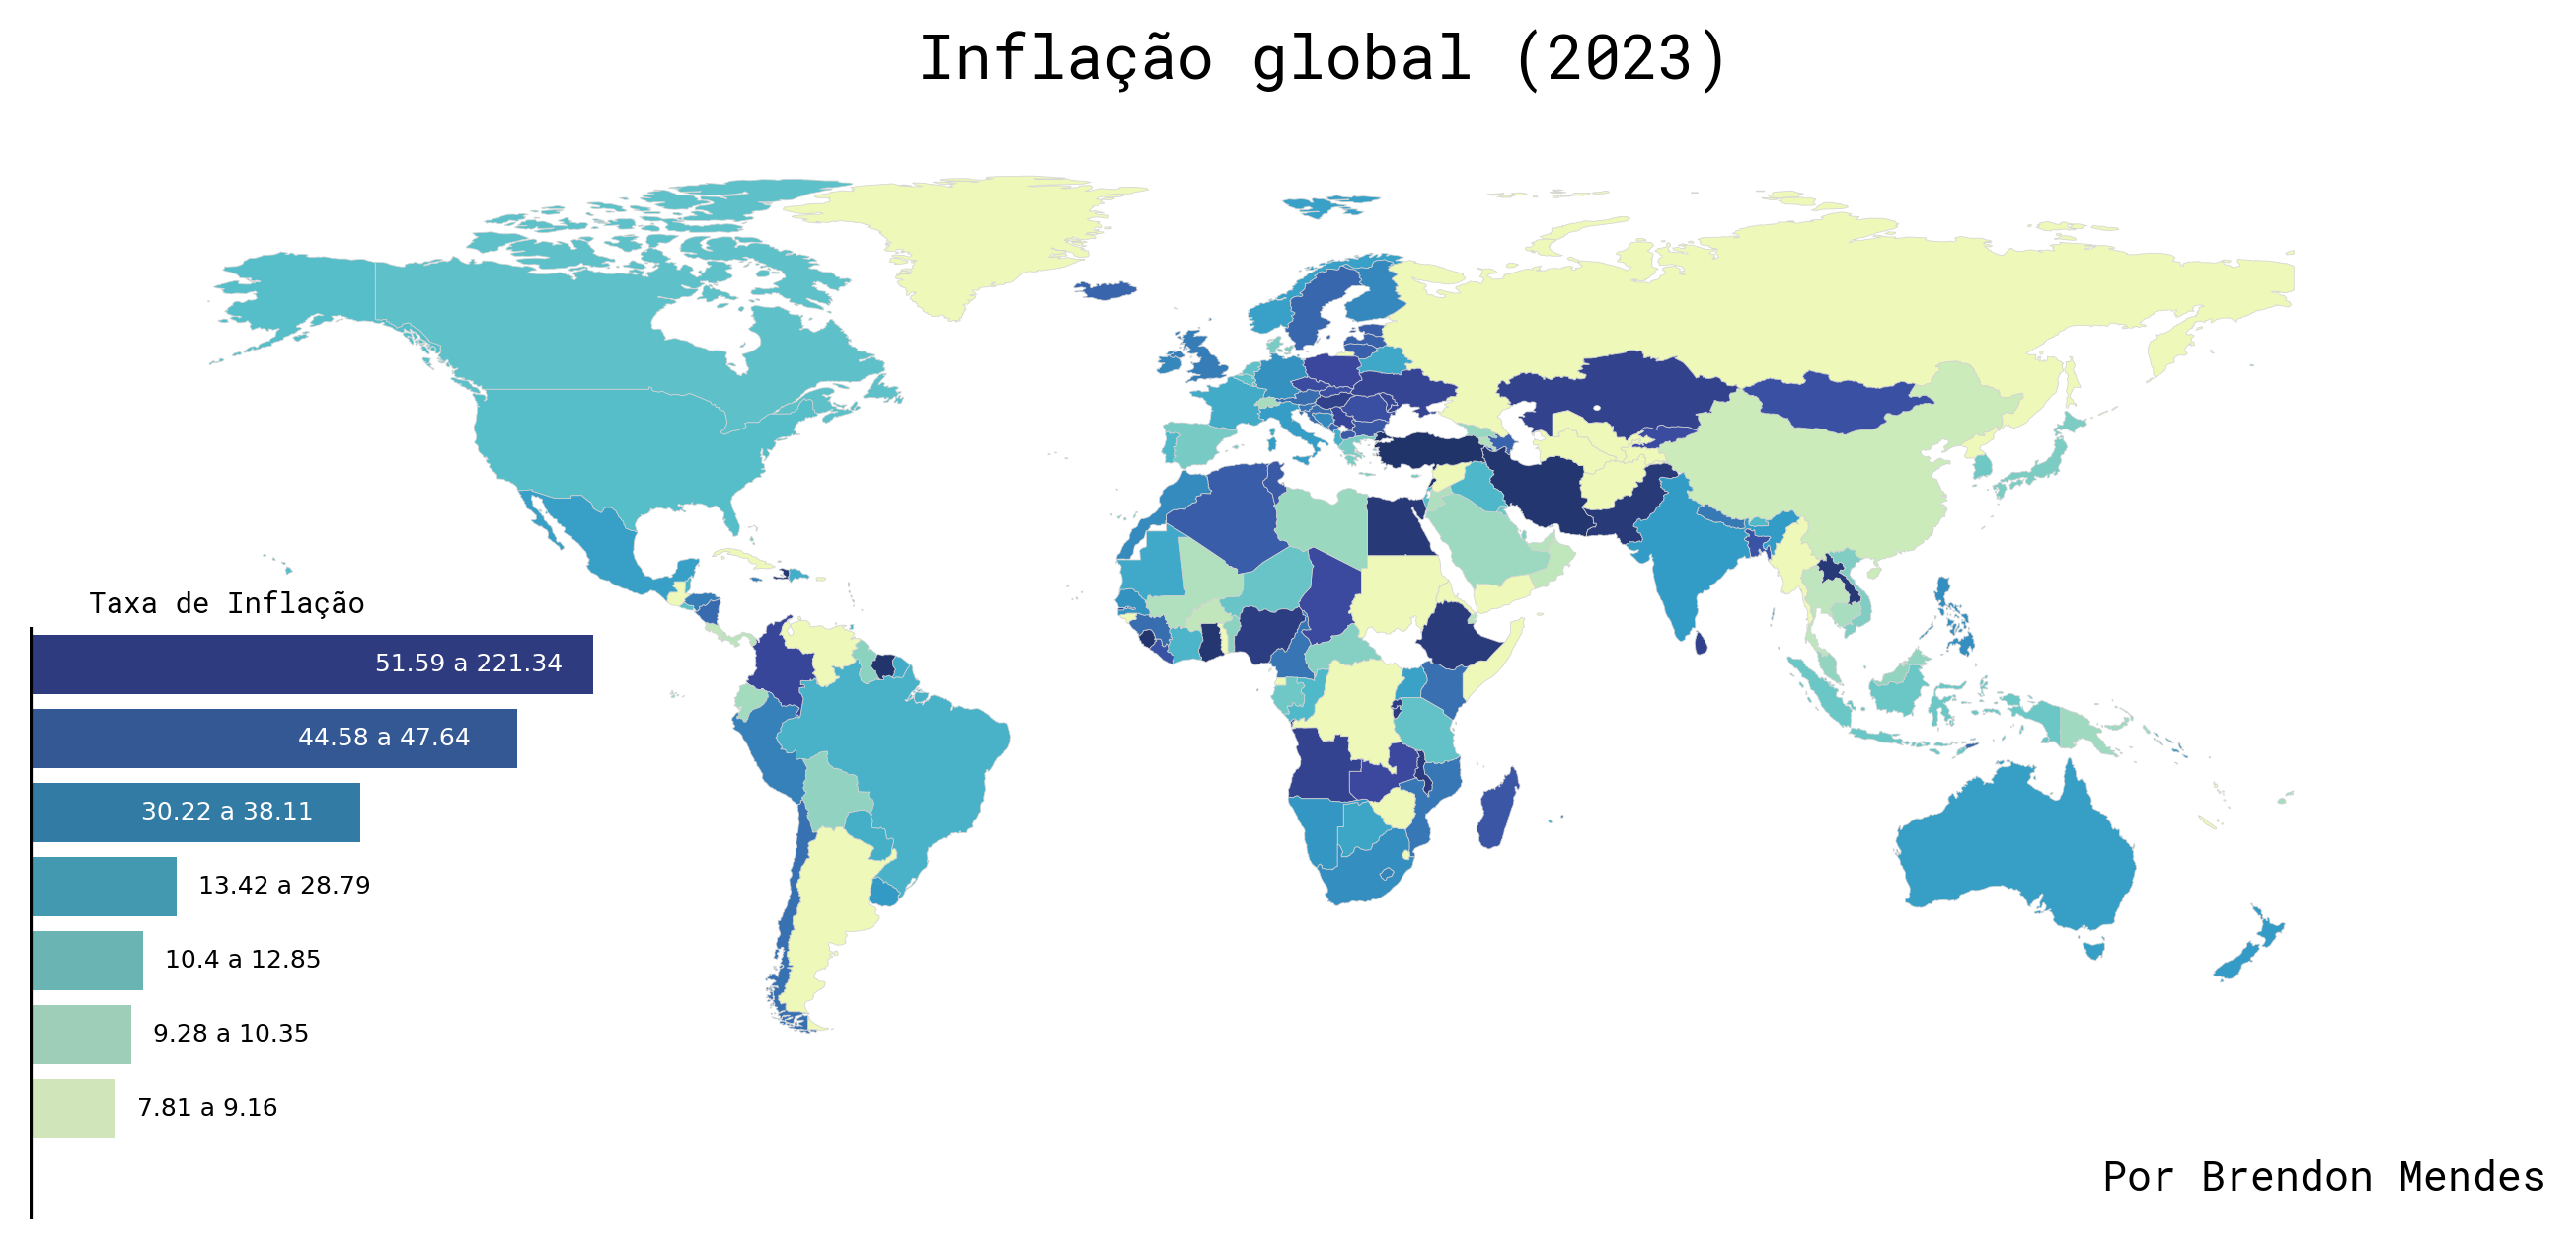

In [ ]:
font = load_font(font_url="https://github.com/google/fonts/blob/main/apache/robotomono/RobotoMono%5Bwght%5D.ttf?raw=true")

palette_name = 'YlGnBu'
cmap = load_cmap(palette_name, cmap_type='continuous')

# Choropleth
fig, ax = plt.subplots(figsize=(10,5),dpi=300)
ax.axis('off')
atlas.plot(ax=ax, column='pct_rank', cmap=cmap, edgecolor='lightgrey',linewidth=0.2,alpha=0.9)

#Barplot
mini_ax = ax.inset_axes(bounds=(0.10,0.08,0.20,0.40), transform=fig.transFigure)
mini_ax.set_axis_off()
sns.barplot(
    data=inflation_group,
    x='inflation_rate_y',
    y='group_inflation',
    palette=palette_name,
    ax=mini_ax,
    hue='group_inflation',
    legend=False
)
mini_ax.axvline(x=0, color='black')
mini_ax.invert_yaxis()

for index, row in inflation_group.iterrows():
    x_pos = row['inflation_rate_y'] - 20 if row['inflation_rate_y'] > 30 else row['inflation_rate_y'] + 2
    y_pos = index
    color = 'white' if index in [0,5,6,7] else 'black'
    mini_ax.text(x_pos,y_pos, row['label'], color=color, size=6, va='center')

fig.text(x=0.40, y=0.85, s="Inflação global (2023)", size=15, font=font)
fig.text(x=0.12, y=0.49, s="Taxa de Inflação", size=7, font=font)
fig.text(x=0.8, y=0.10, s="Por Brendon Mendes", size=10, font=font)

plt.savefig(
    "./inflacao_global"
)

plt.show()